In [ ]:
import requests
import numpy as np
import pandas as pd
import datetime


In [ ]:
'''
Vamos a utilizar la Api de chuck norris para obtener chistes aleatorios.

https://api.chucknorris.io/

Porque... why not?

'''

In [ ]:
#Definimos la funcion para llamar la api y obtener un chiste aleatorio

def get_joke():
    url = 'https://api.chucknorris.io/jokes/random'
    response = requests.get(url)
    data = response.json()
    data = pd.DataFrame([data])

    data['fecha_insercion'] = datetime.datetime.now()
    data = data[['id', 'created_at', 'url', 'value', 'fecha_insercion']]
    return data

#probamos la funcion
joke = get_joke()
joke

In [ ]:
import config
user = config.user
passw = config.passw
host = config.host
port = config.port
database = config.database
schema = config.schema

In [ ]:
#coneccion a redshift
import sqlalchemy
import psycopg2

def conexion_redshift(user, passw, host, port, database):
    conn_string = f'postgresql://{user}:{passw}@{host}:{port}/{database}?sslmode=require'
    engine = sqlalchemy.create_engine(conn_string)
    conn = engine.connect()
    return conn, engine

conn, engine = conexion_redshift(user, passw, host, port, database)

In [ ]:
# creamos la tabla en redshift, puede ser a traves de un query o con pandas

def create_table_query(conn, engine, schema, table_name):
    query = f'''
    CREATE TABLE {schema}.{table_name}(
    id VARCHAR(50),
    created_at TIMESTAMP,
    url VARCHAR(500),
    value VARCHAR(1000),
    fecha_insercion TIMESTAMP
    )
    '''
    conn.execute(query)
    return


def create_table_pandas(conn, engine, schema, table_name):
    data = get_joke()
    data.to_sql(
    con=engine,
    schema=schema,
    name=table_name,
    if_exists='replace',
    index=False,
    dtype={ 'id': sqlalchemy.types.VARCHAR(50),
            'created_at': sqlalchemy.types.TIMESTAMP,
            'url': sqlalchemy.types.VARCHAR(500),
            'value': sqlalchemy.types.VARCHAR(1000),
            'fecha_insercion': sqlalchemy.types.TIMESTAMP
            }
    )
    return


#Comentada la creacion de la tabla, dado que ya esta creada.

# create_table_redshift(conn, engine, schema, 'chuck_jokes3')



In [ ]:
query = f'SELECT * FROM {schema}.chuck_jokes3'
data = pd.read_sql(query, conn)
data = data.drop_duplicates(subset=['id'])
data = data[['id', 'created_at', 'url', 'value', 'fecha_insercion']]

data.to_sql(
    name='chuck_jokes2',
    con=engine,
    schema=schema,
    if_exists='replace',
    index=False,
    dtype={ 'id': sqlalchemy.types.VARCHAR(50),
            'created_at': sqlalchemy.types.TIMESTAMP,
            'url': sqlalchemy.types.VARCHAR(500),
            'value': sqlalchemy.types.VARCHAR(1000),
            'fecha_insercion': sqlalchemy.types.TIMESTAMP
            }
)

In [ ]:
#Insert de registro
get_joke().to_sql(
    name='chuck_jokes2',
    con=engine,
    schema=schema,
    if_exists='append',
    index=False,
    dtype={ 'id': sqlalchemy.types.VARCHAR(50),
            'created_at': sqlalchemy.types.TIMESTAMP,
            'url': sqlalchemy.types.VARCHAR(500),
            'value': sqlalchemy.types.VARCHAR(1000),
            'fecha_insercion': sqlalchemy.types.TIMESTAMP
            }
)

#Aqui podria tomar dos caminos
- 1. Lo simple es concatenar la 'fecha de insercion' y la 'id' y asi siempre tener un id que no se repita (Aburrido!)
- 2. Buscar en la tabla si existe el 'id', "if existe: no se inserta, else: se inserta". Para darle un poquito de complejidad, haré esto.


#Validamos que la id que entrega la api sea la "id del chiste" y una una "id de entrega de datos"

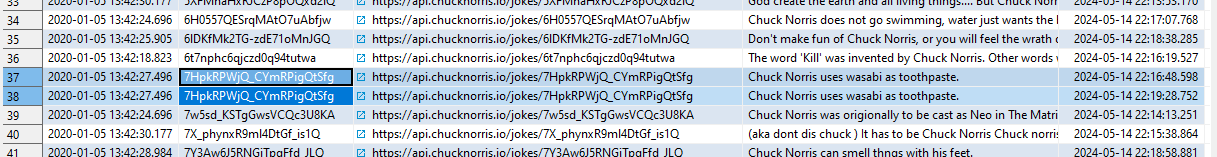

In [39]:
#Insertar un registro sin repetición

def insertar_sin_repeticion(conn, engine, schema, table_name):

    #Obtener registro de id de chistes
    query = f'SELECT id FROM {schema}.{table_name}'
    ids_en_tabla = pd.read_sql(query, conn)['id'].values

    #Nos aseguramos que el id no este en la tabla, si está, obtenemos otro chiste.
    while True:
        data = get_joke()
        joke_id = data['id'][0]

        if joke_id not in ids_en_tabla:
            break
        else:
            print('Chiste repetido, obteniendo otro chiste')
    
    data.to_sql(
            name='chuck_jokes2',
            con=engine,
            schema=schema,
            if_exists='append',
            index=False,
            dtype={ 'id': sqlalchemy.types.VARCHAR(50),
                    'created_at': sqlalchemy.types.TIMESTAMP,
                    'url': sqlalchemy.types.VARCHAR(500),
                    'value': sqlalchemy.types.VARCHAR(1000),
                    'fecha_insercion': sqlalchemy.types.TIMESTAMP
                    }
    )

    return

insertar_sin_repeticion(conn, engine, schema, 'chuck_jokes2')

In [38]:
def insertar_sin_repeticion2(conn, engine, schema, table_name):

    #Nos aseguramos que el id no este en la tabla, si está, obtenemos otro chiste.
    contador = 0
    while True:
        data = get_joke()
        joke_id = data['id'][0]


        query = f'''
        SELECT id FROM {schema}.chuck_jokes2 
        WHERE id = '{joke_id}';
        '''
        if pd.read_sql(query, conn).shape[0] == 0:
            break
        else:
            contador += 1
            print(f'{contador} Chiste repetido, obteniendo otro chiste')

    
    data.to_sql(
            name='chuck_jokes2',
            con=engine,
            schema=schema,
            if_exists='append',
            index=False,
            dtype={ 'id': sqlalchemy.types.VARCHAR(50),
                    'created_at': sqlalchemy.types.TIMESTAMP,
                    'url': sqlalchemy.types.VARCHAR(500),
                    'value': sqlalchemy.types.VARCHAR(1000),
                    'fecha_insercion': sqlalchemy.types.TIMESTAMP
                    }
    )

    return

insertar_sin_repeticion2(conn, engine, schema, 'chuck_jokes2')